# Scikit-Criteria: SIMUS implementations

## Abstract

En este documento se presenta la sintaxis y opciones de la implementacion del método SIMUS, utilizando el stack provisto por Scikit-Criteria.

## Problema

Se utilizara el problema enunciado en el trabajo

> Munier, N., Carignano, C., & Alberto, C. UN MÉTODO DE PROGRAMACIÓN MULTIOBJETIVO. Revista de la Escuela de Perfeccionamiento en Investigación Operativa, 24(39).

### Enunciado
A fin de mostrar una aplicación del método, se utiliza un ejemplo
48
SECCION APLICACIONESINVESTIGACION OPERATIVA - AÑO XXIV - No 39 - PAGINAS 44 a 54 - MAYO 2016
sobre planificación urbana, propuesto en Lliso (2014) 2 .

Desde hace algunas décadas y debido a los cambios en la industria
del transporte ferroviario y marítimo en casi todas las ciudades hay espacios
vacíos, por lo general céntricos, los cuales eran ocupados por las estaciones
de ferrocarril, patios de ferrocarril y muelles. Estas parcelas abandonadas son
el blanco de los municipios para ser usadas en la construcción de parques,
edificios de viviendas, oficinas gubernamentales, centros comerciales, etc.
Suelen ser grandes parcelas que pueden ser adecuadas para varios usos
diferentes al mismo tiempo, razón por la cual el gobierno municipal se
encuentra ante un dilema ya que es deseable seleccionar la alternativa de uso
que mejor sirva a la ciudad.

#### CASO: REHABILITACIÓN DE TIERRAS

Una importante ciudad portuaria se ha visto afectada por el cambio en
la modalidad de transporte marítimo, cuando comenzó el transporte de
contenedores a mediados del siglo 20. La ciudad se quedó con 39 hectáreas
de muelles vacíos, así como los almacenes y una terminal ferroviaria.

El municipio tiene que decidir qué hacer con esta tierra y desarrolló un
Plan Maestro basado en tres proyectos diferentes:

- Proyecto 1: Torres Corporativas - Hoteles - Marina - Pequeño Parque.
- Proyecto 2: Torres de Viviendas - Zona Comercial en la antigua
  estación de ferrocarril.
- Proyecto 3: Centro de Convenciones - Gran Parque y área recreativa.

Los criterios que considera para el análisis de las propuestas se
refieren a:

- Criterio 1: Generación de Trabajo
- Criterio 2: Espacio Verde Recuperado
- Criterio 3: Factibilidad Financiera
- Criterio 4: Impacto Ambiental

Para el criterio 2 se especifica un límite máximo, mientras que los
restantes criterios no tienen restricción definida para el lado derecho.

El Decisor considera a los cuatro criterios como objetivos, por lo que
se deberán resolver cuatro programas lineales con tres restricciones cada
uno.

Los datos se detallan en la tabla siguiente.

|               |Proyecto 1 | Proyecto 2 | Proyecto 3 | VLD | Acción    |
| ------------- |-----------|------------|------------|-----|-----------|
| Criterio 1    | 250       |  130       | 350        | -   | Maximizar |
| Criterio 2    | 120       |  200       | 340        | 500 | Maximizar |
| Criterio 3    | 20        |  40        | 15         | -   | Minimizar |
| Criterio 4    | 800       |  1000      | 600        | -   | Maximizar |

## El modelo

```python
from skcriteria.madm import simus
dm = simus.SIMUS()
```

- El metodo SIMUS se configura con la llamada `simus.SIMUS`. 
- El unico parametro opcional es **solver**. Este parámetro se utiliza
  para determinar que resolutor de programación lineal se ha de utilizar.
- Entre Los resolutores disponibles se encuentran 
  [coin-mp](https://projects.coin-or.org/CoinMP) (este es el por defecto),
  [cplex](https://en.wikipedia.org/wiki/CPLEX),
  [gurobi](https://en.wikipedia.org/wiki/Gurobi) y 
  [glpk](https://en.wikipedia.org/wiki/GNU_Linear_Programming_Kit)
- Para utilizar cplex, gurobi y glpk es necesario instalarlos y configurarlos
  dentro de scikit-criteria (se explicara cuando se implemente)

Ejemplo de creación de un modelo con los solvers gplk y cplex:

```python
# utilizando glpk
dm = simus.SIMUS(solver="glpk")

# utilizando cplex
dm = simus.SIMUS(solver="cplex")
```

## Los Datos

El metodo implementado dentro scikit-criteria recibe los datos en el mismo formato que todos los demas métodos:

- Una matriz de alternativa, donde cada fila es una alaternativas y cada columna es un criterio. Internamente SIMUS transpone esta matris para su operación)
- Una vector de criterios que indica si el criterio es maximizaro o minimizar.

Opcionales:

-  Vector de pesos (ignorado por SIMUS)
-  Nombre de las alternativas
-  Nombre de los criterios

**Ejemplo del paper:**

In [9]:
from skcriteria import Data

data = Data(
    mtx=[[250, 120, 20, 800],
         [130, 200, 40, 1000],
         [350, 340, 15, 600]],
    criteria=[max, max, min, max],
    anames=["Proyecto 1", "Proyecto 2", "Proyecto 3"],
    cnames=["Criterio 1", "Criterio 2", "Criterio 3", "Criterio 4"])
data

ALT./CRIT.,Criterio 1 (max),Criterio 2 (max),Criterio 3 (min),Criterio 4 (max)
Proyecto 1,250,120,20,800
Proyecto 2,130,200,40,1000
Proyecto 3,350,340,15,600


### Resolviendo el problema

Anteriormente habiamos creado el modelo llamado **`dm`**. **`dm`** tiene una funcón llamada solve que recibe el objeto **`data`** que creamos y opcionalmente un parametro llamado **`b`** que representa el vector del lado
derecho y que tiene que tener la misma cantidad de valores que criterios tenga los datos.

En el caso del ejemplo 

```python
decision = dm.decide(data, b=[None, 500, None, None]
decision
```

![](imgs/simus_rank.png)

Todos los calculos intermedios como: vectores de subordinacion, puntajes por ambos procedimientos, los resultados de los algoritmos de programacion lineal y otros; estan
guardados dentro de la variable de **`dec.e_`** (esta variable de llama "e" por extra, ya que depende el metodo a utilizar guarda diferentes cosas (en topsis guarda el vector de cercanias por ejemplo))

![](imgs/simus_e_2.png)
![](imgs/simus_e_.png)

#### Por que data tiene esta forma?

Por que con los mismos datos podemos alimentar y comparar diferentes metodos. Por ejemplo

**TOPSIS**

In [42]:
from skcriteria.madm import closeness
closeness.TOPSIS().decide(data)

ALT./CRIT.,Criterio 1 (max),Criterio 2 (max),Criterio 3 (min),Criterio 4 (max),Rank
Proyecto 1,250,120,20,800,2
Proyecto 2,130,200,40,1000,3
Proyecto 3,350,340,15,600,1


**ELECTRE 1**

In [43]:
from skcriteria.madm import electre
electre.ELECTRE1().decide(data)

ALT./CRIT.,Criterio 1 (max),Criterio 2 (max),Criterio 3 (min),Criterio 4 (max),Kernel
Proyecto 1,250,120,20,800,
Proyecto 2,130,200,40,1000,@
Proyecto 3,350,340,15,600,@


**Suma Ponderada**

In [45]:
from skcriteria.madm import simple
simple.WeightedSum().decide(data)

ALT./CRIT.,Criterio 1 (max),Criterio 2 (max),Criterio 3 (min),Criterio 4 (max),Rank
Proyecto 1,250,120,20,800,2
Proyecto 2,130,200,40,1000,3
Proyecto 3,350,340,15,600,1


Ademas que el objeto data tiene capacidades graficas como:

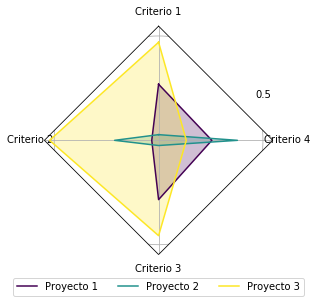

In [49]:
data.plot();

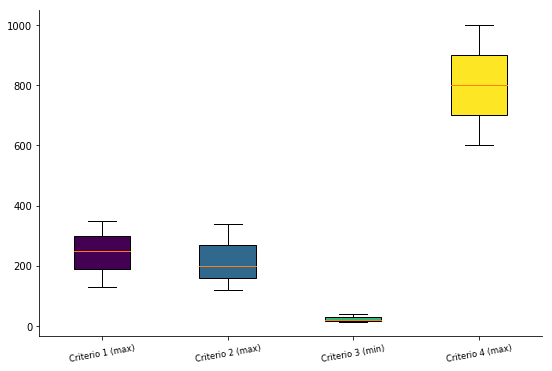

In [48]:
data.plot.box();